In [1]:
from trinity_post_process_v2 import read_salmon_sf, read_fasta, ORF, Gene, Isoform,  IsoformRank, filter_orf

In [2]:
# read trinity fasta
fasta_file = "/data5/xzg_data/arabidopsis_single_cell_atalas/rna-seq/metrics/trinity_ss_flnc.fasta"
fasta_dict = read_fasta(fasta_file)

fasta_with_lr_support = []

for key, value in fasta_dict.items():
    if "LR" in value.description:
        fasta_with_lr_support.append(key)

fasta_with_lr_support = set(fasta_with_lr_support)


# read salmon output 
salmon_output_sf = [
    "/home/xzg/project2/arabidopsis_single_cell_atalas/rna-seq/metrics/salmon/SRR25073470_quant.sf",
    "/home/xzg/project2/arabidopsis_single_cell_atalas/rna-seq/metrics/salmon/SRR25073471_quant.sf",
    "/home/xzg/project2/arabidopsis_single_cell_atalas/rna-seq/metrics/salmon/SRR25073472_quant.sf"
]
tpm_dict = read_salmon_sf(salmon_output_sf)


# Read and parse the BED file
# store orf in dict
bed_file = "/data5/xzg_data/arabidopsis_single_cell_atalas/rna-seq/metrics/transdecoer.standard.code/trinity_ss_flnc.fasta.transdecoder.bed"

# tx : [orf1, orf2, orf3]
tx_orf_dict = {}

with open(bed_file, 'r') as file:
    # Skip the header
    next(file)
    
    # Parse each line
    for line in file:
        orf = ORF.parse_bed_line(line)
        if orf.transcript_name in fasta_with_lr_support:
            orf.lr_support = True
        transcript_name = orf.transcript_name
        if transcript_name not in tx_orf_dict:
            tx_orf_dict[transcript_name] = []
        tx_orf_dict[transcript_name].append(orf)


tx_orf_dict = filter_orf(tx_orf_dict, tpm_dict)


# 解析orf_dict, 得到isoform_dict
# gene: [tx1, tx2, tx3 ....]
gene_tx_dict = {}

for tx, orfs in tx_orf_dict.items():
    gene_name = "_".join(tx.split("_")[:-1])
    isoform = Isoform(tx, orfs)
    if gene_name not in gene_tx_dict:
        gene_tx_dict[gene_name] = []
    gene_tx_dict[gene_name].append(isoform)


# 解析isoform_dict, 得到gene_dict
gene_dict = {}
for gene_name, isoforms in gene_tx_dict.items():
    
    gene_dict[gene_name] = Gene(gene_name, isoforms)

# 将基因按照isoform数目分成两类
single_isoform_gene = [ v for v in gene_dict.values() if v.size == 1]
multi_isoform_gene = [ v for v in gene_dict.values() if v.size > 1]

print(f"single isoform gene: {len(single_isoform_gene)}")
print(f"multi isoform gene: {len(multi_isoform_gene)}")

# 对于多个multi_isoform_gene的情况
good_gene_list = []
bad_gene_list = []
for gene in multi_isoform_gene:
    isoforms = gene.isoforms
    # 获取每个转录本的预测结果, 从中选取得分最高的
    highest_isoform = ""
    # 无穷小
    highest_score = float("-inf") 

    for isoform in isoforms:
        if isoform.score > highest_score:
            highest_score = isoform.score 
            highest_isoform = isoform
    
    if highest_isoform.rank == IsoformRank.single_complete:
        good_gene_list.append(gene)
    else:
        bad_gene_list.append(gene)



single isoform gene: 10159
multi isoform gene: 13420


In [3]:
# 基于gene_dict筛选fasta_dict
from Bio import SeqIO
with open("/home/xzg/project2/arabidopsis_single_cell_atalas/rna-seq/transcriptome/trinity_ss_flnc.Trinity.fasta.filtered", 'w') as file:
    for gene_name, gene in gene_dict.items():
        for isoform in gene.isoforms:
            isoform_name = isoform.name
            SeqIO.write(fasta_dict[isoform_name], file, "fasta")


In [168]:
import pysam


def calculate_rf_fr_coverage(bam_path, chromosome):
    """Calculate RF and FR coverage for a given chromosome in the BAM file."""
    # 打开BAM文件
    bamfile = pysam.AlignmentFile(bam_path, "rb")

    coverages_rf = {}
    coverages_fr = {}

    # 迭代 chr1 上每个 pileup 位置
    for pileupcolumn in bamfile.pileup(chromosome):
        # 初始化计数
        read1_rev_read2_fwd_count = 0
        read1_fwd_read2_rev_count = 0

        # 遍历每个位置上的 READ
        for pileupread in pileupcolumn.pileups:
            # 跳过删除的或不匹配参考序列的 read
            if pileupread.is_del or pileupread.is_refskip:
                continue

            # 获取 alignment 对象
            read = pileupread.alignment

            # 确保 read 是配对的、第一条、非次要比对
            if not read.is_paired or read.is_secondary :
                continue

            # 根据配对的方向分类计数
            if read.is_read1 and read.is_reverse and not read.mate_is_reverse:
                # R1 is rev, R2 is fwd
                read1_rev_read2_fwd_count += 1
            elif read.is_read2 and not read.is_reverse and read.mate_is_reverse:
                # R2 is fwd, R1 is rev
                read1_rev_read2_fwd_count += 1
            elif read.is_read1 and not read.is_reverse and read.mate_is_reverse:
                # R1 is fwd, R2 is rev
                read1_fwd_read2_rev_count += 1
            elif read.is_read2 and read.is_reverse and not read.mate_is_reverse:
                # R2 is rev, R1 is fwd
                read1_fwd_read2_rev_count += 1


        # 获取当前位置
        position = pileupcolumn.reference_pos
        coverages_rf[position] = read1_rev_read2_fwd_count
        coverages_fr[position] = read1_fwd_read2_rev_count

    # 关闭 BAM 文件
    bamfile.close()

    return coverages_rf, coverages_fr


In [169]:
# 示例使用:
bam_file_path ="/data5/xzg_data/arabidopsis_single_cell_atalas/rna-seq/xzg_pipeline/uncomplete.bam"

chromosome_name = "TRINITY_DN10837_c0_g2" # 替换为你想要处理的染色体名

# 计算覆盖度并分别得到 RF 和 FR 的覆盖度字典
coverages_rf, coverages_fr = calculate_rf_fr_coverage(bam_file_path, chromosome_name)


In [170]:
# 获取染色体的长度
chromosome_length = len(fasta_dict[chromosome_name].seq)

# 输出到文件中
with open("coverage.tsv", "w") as file:
    for pos in range(chromosome_length):
        file.write(f"{pos}\t{coverages_rf.get(pos, 0)}\t{coverages_fr.get(pos, 0)}\n")


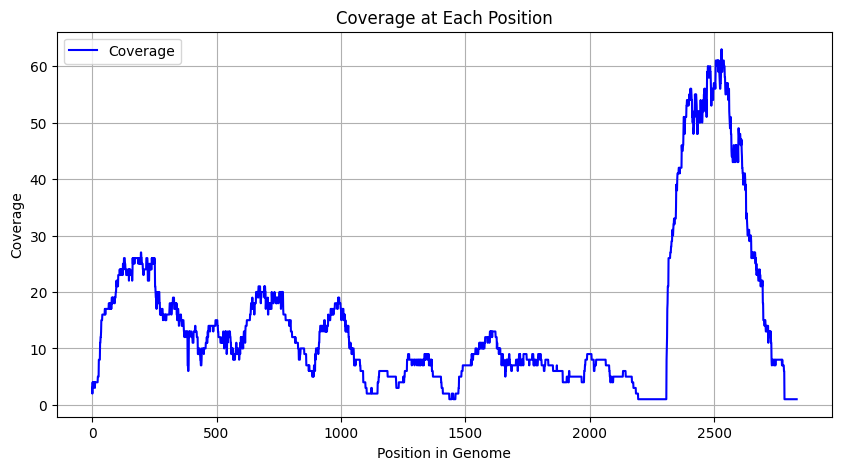

In [172]:
import matplotlib.pyplot as plt

# 假设你已经有了coverage_at_each_position列表
# coverage_at_each_position = [(pos1, cov1), (pos2, cov2), ...]

# 分离位置和覆盖度数据
cov = coverages_rf
positions = cov.keys()
coverages = cov.values()

# 创建一个新的图表
plt.figure(figsize=(10, 5))  # 可以调整图表大小

# 绘制覆盖度曲线
plt.plot(positions, coverages, label="Coverage", color="blue")

# 添加标题和标签
plt.title("Coverage at Each Position")
plt.xlabel("Position in Genome")
plt.ylabel("Coverage")

# 显示图例
plt.legend()

# 显示网格
plt.grid(True)

# 可以设置x轴的范围，如果你只对某个区域的覆盖度感兴趣
# plt.xlim(xmin, xmax)

# 保存图表到文件
plt.savefig("coverage_plot.png")

# 显示图表
plt.show()


In [147]:
coverages_fr

{0: 1,
 15: 9,
 16: 2,
 17: 6,
 18: 3,
 19: 7,
 20: 2,
 21: 16,
 22: 7,
 23: 16,
 25: 59,
 26: 24,
 27: 14,
 28: 7,
 30: 1,
 31: 1,
 33: 5,
 34: 1,
 36: 6,
 37: 13,
 38: 4,
 39: 8,
 40: 7,
 42: 2,
 43: 14,
 44: 1,
 45: 6,
 46: 3,
 47: 26,
 48: 5,
 49: 1,
 51: 2,
 52: 2,
 55: 1,
 57: 1,
 58: 10,
 59: 2,
 60: 1,
 61: 9,
 63: 11,
 64: 4,
 65: 1,
 67: 1,
 69: 10,
 70: 1,
 72: 1,
 74: 1,
 76: 5,
 78: 20,
 79: 1,
 80: 1,
 85: 2,
 86: 2,
 87: 1,
 88: 2,
 89: 1,
 90: 1,
 91: 4,
 92: 3,
 93: 11,
 95: 5,
 97: 10,
 98: 9,
 99: 5,
 100: 10,
 101: 3,
 102: 7,
 104: 4,
 105: 10,
 107: 1,
 111: 2,
 113: 1,
 114: 1,
 115: 12,
 116: 10,
 117: 2,
 118: 3,
 119: 2,
 120: 3,
 121: 13,
 122: 4,
 123: 5,
 125: 5,
 127: 2,
 130: 7,
 132: 2,
 133: 2,
 135: 2,
 137: 13,
 138: 2,
 139: 15,
 140: 2,
 142: 1,
 143: 9,
 144: 2,
 146: 4,
 148: 1,
 149: 3,
 150: 4,
 152: 2,
 155: 4,
 156: 12,
 157: 7,
 158: 2,
 159: 3,
 160: 2,
 162: 5,
 163: 11,
 164: 1,
 166: 8,
 167: 3,
 168: 1,
 169: 5,
 170: 3,
 171: 1,
 174: 5

In [88]:
from trinity_post_process_v2 import OrderedNodes, plot_gene_nodes

In [89]:
# fasta_dict
node_dict = {}
for key,value in fasta_dict.items():
    node_dict[key] = OrderedNodes.create_node_from_string(value.description)


In [99]:

# 对fair_gene_list 进行分析
#gene_id = fair_gene_list[12]
gene_id = "TRINITY_DN14980_c0_g2"
tx_list = gene_dict[gene_id]
descriptions = [fasta_dict[tx.name].description for tx in tx_list.isoforms]

In [100]:
descriptions

['TRINITY_DN14980_c0_g2_i1 len=1915 path=[0:0-568 1:569-643 3:644-669 4:670-778 6:779-807 7:808-958 9:959-1100 10:1101-1425 12:1426-1452 13:1453-1717 15:1718-1741 17:1742-1914] LR$|m54081_180520_160540/72352023/ccs',
 'TRINITY_DN14980_c0_g2_i3 len=1915 path=[0:0-568 1:569-643 3:644-669 4:670-778 6:779-807 7:808-958 9:959-1100 11:1101-1425 12:1426-1452 14:1453-1717 15:1718-1741 17:1742-1914] LR$|m54081_180520_160540/72352023/ccs',
 'TRINITY_DN14980_c0_g2_i4 len=1989 path=[0:0-568 2:569-649 3:650-675 5:676-784 6:785-813 8:814-958 9:959-1100 10:1101-1425 12:1426-1452 13:1453-1717 15:1718-1741 16:1742-1988] LR$|m54081_180520_160540/46334515/ccs']

In [101]:

gene_nodes = [OrderedNodes.create_node_from_string(description) for description in descriptions]


NameError: name 'gene_id' is not defined

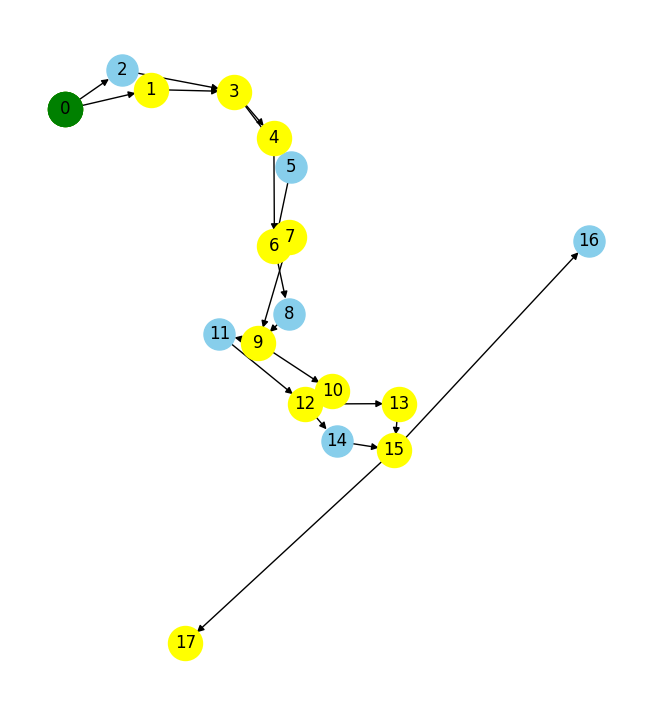

In [102]:
plot_gene_nodes(gene_nodes, gene_dict, fasta_dict)

In [91]:
gene_node = node_dict['TRINITY_DN14980_c0_g2']

KeyError: 'TRINITY_DN14980_c0_g2'

In [ ]:
plot_gene_nodes()